In [1]:
import os
import tensorflow as tf
import cv2 as cv
import glob
import h5py
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout, Add, Activation, Input, BatchNormalization, Conv2DTranspose,concatenate
from tensorflow.keras.optimizers import Adam
from math import ceil
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%matplotlib inline

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4814587421062048114
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3149044121
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11357724630705364573
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
def create_dataset():
    dataset_path = glob.glob('./Dataset/training/image_2/*.png')
    ground_truth = glob.glob('./Dataset/training/gt_image_2/*.png')
    #print(dataset_path)
    #print(ground_truth)
    #labels = [0 if 'textbox' in addr else 1 for addr in dataset_path]
    #images = cv.imread(dataset_path)
    
    compressed=list(zip(dataset_path, ground_truth))
    #shuffle(compressed)
    addrs, labels = zip(*compressed)
    
    train_addrs = addrs[0:int(0.6*len(addrs))]
    train_labels = labels[0:int(0.6*len(labels))]
    test_addrs = addrs[int(0.8*len(addrs)):]
    test_labels = labels[int(0.8*len(labels)):]
    
    train_x_l = len(train_addrs)
    train_y_l = len(train_labels)
    test_x_l = len(test_addrs)
    test_y_l = len(test_labels)
    
    train_shape = (train_x_l,  256, 256, 3)
    train_output_shape = (train_y_l, 256, 256, 3)
    test_shape = (test_x_l,  256, 256, 3) #375,1242
    test_output_shape = (test_y_l, 256, 256, 3)
    
    # Abrir un archivo HDF5 en modo escritura y crear los datasets
    hdf5_file = h5py.File('./Dataset/pictures_dataset.h5', mode='w')
    hdf5_file.create_dataset("train_img", train_shape, np.int8)
    hdf5_file.create_dataset("test_img", test_shape, np.int8)
    hdf5_file.create_dataset("train_mean", train_shape[1:], np.float32)

    hdf5_file.create_dataset("train_labels", train_output_shape, np.int8)        
    hdf5_file.create_dataset("test_labels", test_output_shape, np.int8)
    
    #LoadImages
    #hdf5_file["train_labels"][...] = train_labels
    #hdf5_file["test_labels"][...] = test_labels

    train_shape=hdf5_file["train_img"].shape
    mean = np.zeros(train_shape[1:], np.float32)
    
    #Training addresses
    for i in range(len(train_addrs)):
        addr = train_addrs[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["train_img"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #Training output addresses
    for i in range(len(train_labels)):
        addr = train_labels[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["train_labels"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #Testing addresses
    for i in range(len(test_addrs)):
        addr = test_addrs[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["test_img"][i, ...] = img[None]
    
    #Testing output addresses
    for i in range(len(test_labels)):
        addr = test_labels[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["test_labels"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #hdf5_file["train_mean"][...] = mean
    hdf5_file.close()
    
create_dataset()

In [2]:
def extract_dataset():
    batch_size = 10
    batch_n = 100
    # Abrir el archivo HDF5, modo lectura
    hdf5_file = h5py.File('./Dataset/pictures_dataset.h5', "r")
    
    # Determinar la longitud del dataset de entrenamiento
    data_num = hdf5_file["train_img"].shape[0]
    test_num = hdf5_file["test_img"].shape[0]
    
    # Crear una lista de lotes para barajear los datos
    batches_list = list(range(int(ceil(float(data_num) / batch_size))))
    shuffle(batches_list)
    
    training_list = list(range(int(ceil(float(test_num) / batch_size))))

    # Recorramos los lotes
    for n, i in enumerate(batches_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, data_num])  # Indice de la última imagen en este lote

        # Leer las imágenes del lote
        training_images = hdf5_file["train_img"][i_s:i_e]
        
        # Leer etiquetas
        training_labels = hdf5_file["train_labels"][i_s:i_e]
        
        #print (n+1, '/', len(batches_list))
        #print (f"Etiqueta: {training_labels[0]}")
        '''
        plt.imshow(training_images[0])
        plt.show()
        plt.imshow(training_labels[0])
        plt.show()
        '''
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
    for n, i in enumerate(training_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, test_num])  # Indice de la última imagen en este lote

        # Leer las imágenes del lote
        test_images = hdf5_file["test_img"][i_s:i_e]
        
        # Leer etiquetas
        test_labels = hdf5_file["test_labels"][i_s:i_e]
        
        #print (n+1, '/', len(batches_list))
        #print (f"Etiqueta: {test_labels[0]}")
    
        #plt.imshow(test_images[0])
        #plt.show()   
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
    hdf5_file.close()
    return (training_images, training_labels), (test_images, test_labels)

var = extract_dataset()

In [3]:
def load_dataset_from_route():
    #(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    (train_images, train_labels),(test_images, test_labels) = extract_dataset()
    training_set = (train_images, train_labels)
    test_set = (test_images, test_labels)
    return training_set, test_set

training_set, test_set = load_dataset_from_route()
#class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
training_images = training_set[0]/255
training_labels = training_set[1]
test_images = test_set[0]/255
test_labels = test_set[1]



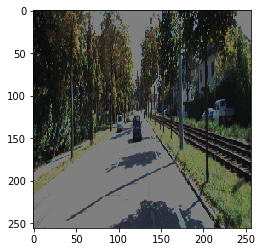

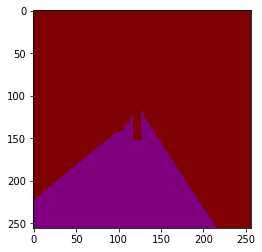

Train on 10 samples, validate on 8 samples
Epoch 1/5
10/10 [==============================] - 8s 837ms/sample - loss: 6595.6170 - acc: 0.7534 - mse: 6595.6172 - val_loss: 6103.8156 - val_acc: 1.0000 - val_mse: 6103.8159
Epoch 2/5
10/10 [==============================] - 1s 102ms/sample - loss: 6581.4228 - acc: 0.9884 - mse: 6581.4229 - val_loss: 6103.8146 - val_acc: 1.0000 - val_mse: 6103.8145
Epoch 3/5
10/10 [==============================] - 1s 99ms/sample - loss: 6581.4183 - acc: 0.9875 - mse: 6581.4189 - val_loss: 6103.8146 - val_acc: 1.0000 - val_mse: 6103.8145
Epoch 4/5
10/10 [==============================] - 1s 99ms/sample - loss: 6581.4183 - acc: 0.9987 - mse: 6581.4189 - val_loss: 6103.8146 - val_acc: 1.0000 - val_mse: 6103.8145
Epoch 5/5
10/10 [==============================] - 1s 104ms/sample - loss: 6581.4183 - acc: 0.9996 - mse: 6581.4180 - val_loss: 6103.8146 - val_acc: 1.0000 - val_mse: 6103.8145


In [17]:
def create_model(nClasses):
    img_rows = 256
    img_cols = 256
    lr = 0.05
    #nClasses = 3

    inputs = Input((img_rows, img_cols, 3))
    x = Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    p1 = x
    # Block 2
    x = Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    p2 = x

    # Block 3
    x = Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    p3 = x

    # Block 4
    x = Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    p4 = x

    # Block 5
    # x = Conv2D(512, (3, 3), activation=None, padding='same', name='block5_conv1')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Conv2D(512, (3, 3), activation=None, padding='same', name='block5_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Conv2D(512, (3, 3), activation=None, padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    # p5 = x

    vgg  = Model(inputs , x)
    
    ### pool4 (16,32,256) --> up1 (32,64,256)
    o = p4
    o = Conv2D(256, (5, 5), activation=None, padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    o = Conv2D(256, (3, 3), activation=None, padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    o = Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(o)

    ### pool3 (32,64,128) --> (32,64,256)
    o2 = p3
    o2 = Conv2D(256, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Activation('relu')(o2)
    
    ### concat1 [(32,64,256), (32,64,256)]
    o = concatenate([o, o2], axis=3)
    o = Conv2D(256, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    ### up2 (32,64,512) --> (64,128,128)
    o = Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(o)
    o = Conv2D(128, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    ### pool2 (64,128,64) --> (64,128,128)
    o2 = p2
    o2 = Conv2D(128, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Activation('relu')(o2)

    ### concat2 [(64,128,128), (64,128,128)]
    o = concatenate([o, o2], axis=3)
    
    ### up3 (64,128,256) --> (128,256,64)
    o = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)
    o = Conv2D(64, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    ### pool1 (128,256,64) --> (128,256,32)
    o2 = p1
    o2 = Conv2D(32, (3, 3), activation=None, padding='same')(o2)
    o2 = BatchNormalization()(o2)
    o2 = Activation('relu')(o2)

    ### concat3 [(128,256,64), (128,256,32)] --> (128,256,32)
    o = concatenate([o, o2], axis=3)
    o = Conv2D(32, (3, 3), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    ### up (128,256,32) --> (256,512,32)
    o = Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(o)
    ### mask out (128,256,32) --> (256,512,3)
    o = Conv2D(nClasses, (3, 3), padding='same')(o)
    o = Activation('sigmoid')(o)
    
    model = Model(inputs=[inputs], outputs=[o])
    
    #model.compile(optimizer=Adam(lr=lr, decay=1e-6), loss=pixelwise_binary_ce, metrics=[dice_coef])
    return model

vgg_model = create_model(3)
#vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.05, decay=1e-6), metrics=['acc', 'mse'])
#vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])
vgg_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005, decay=1e-6), metrics=['acc', 'mse'])
#vgg_model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['acc', 'mse'])
#vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])
plt.imshow(training_images[0])
plt.show()

plt.imshow(training_labels[0])
plt.show()
#vgg_model.summary()
vgg_model.fit(x=training_images, y=training_labels,batch_size = 1, epochs = 5, verbose = 1,callbacks = None, validation_split=0.0, validation_data=(test_images,test_labels) )
#ValueError: A target array with shape (30, 256, 256, 3) was passed for an output of shape (None, 56, 56, 2) 
#while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.
#Esto se refiere a que output_graph es un arreglo con dimensiones (None, 56, 56,2)
vgg_model.save('modelo_completo_sgd_4clases_sgd_mse.h5')
vgg_model.save_weights('pesos_modelo_sgd_4clases_sgd_mse.h5')

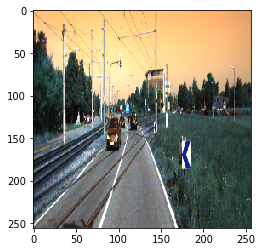

(1, 256, 256, 3)


True

In [18]:
image = cv.imread('./Dataset/testing/image_2/um_000003.PNG')
image = cv.resize(image, (256,256))
plt.imshow(image)
plt.show()
image = np.resize(image, (1,256,256,3))
#plt.imshow(image)
image = tf.cast(image, tf.float32)
print(image.shape)
vgg_model = load_model('./modelo_completo_sgd_4clases_sgd_mse.h5')
prediction = vgg_model.predict(image, batch_size = None, verbose = 0, steps = None, callbacks = None, max_queue_size = 10, workers = 1, use_multiprocessing = False)
#image_result = image_result * 255
cv.imwrite('./prediction_pepePecas_por_255.jpg',prediction[0]*255)
cv.imwrite('./prediction_pepePecas_normal.jpg',prediction[0])
#plt.imshow(image_result)
#plt.show()
#predicted = np.argmax(prediction.shape[0], axis=1)
#print(class_names[predicted])